# Task 2

-------

# Predictive modeling of customer bookings

## Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [262]:
# imports 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

In [207]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

## Data conversion
Before we compute any statistics on the data, lets do any necessary data conversion

### Flight Day

In [209]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [210]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [211]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [212]:
df.groupby("flight_day").size()

flight_day
1    8102
2    7673
3    7674
4    7424
5    6761
6    5812
7    6554
dtype: int64

We can notice that most of the customers fligh on Monday while Saturday has the smallest number flights.

### Sales Channel

In [213]:
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [214]:
df.groupby("sales_channel").size()

sales_channel
Internet    44382
Mobile       5618
dtype: int64

In [215]:
perc_internet = df["sales_channel"].value_counts()["Internet"]/ df.sales_channel.count() *100
perc_mobile = df["sales_channel"].value_counts()["Mobile"] / df.sales_channel.count() *100
print(f"{perc_internet}% of bookings is done through Internet")
print(f"{perc_mobile}% of bookings is done through Mobile")

88.764% of bookings is done through Internet
11.236% of bookings is done through Mobile


### Trip Type

In [216]:
df.groupby("trip_type").size()

trip_type
CircleTrip      116
OneWay          387
RoundTrip     49497
dtype: int64

In [217]:
perc_round = df.trip_type.value_counts().values[0]/ df.trip_type.count() *100
perc_oneway = df.trip_type.value_counts().values[1]/ df.trip_type.count() *100
perc_circle = df.trip_type.value_counts().values[2]/ df.trip_type.count() *100

print(f"Percentage of round trips is: {perc_round}%")
print(f"Percentage of one way trips is: {perc_oneway}%")
print(f"Percentage of circle trips is: {perc_circle}%")

Percentage of round trips is: 98.994%
Percentage of one way trips is: 0.774%
Percentage of circle trips is: 0.232%


### Flight duration

In [218]:
# Changine flight duration type from float to int
df["flight_duration"].unique()

array([5.52, 5.07, 7.57, 6.62, 7.  , 4.75, 8.83, 7.42, 6.42, 5.33, 4.67,
       5.62, 8.58, 8.67, 4.72, 8.15, 6.33, 5.  , 4.83, 9.5 , 5.13])

## Booking Origin

In [219]:
# Count the occurrences of each country
country_counts = df["booking_origin"].value_counts()
print(country_counts)

Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64


In [220]:
# Select the top 15 countries
top_15_countries = country_counts.head(15)

print(top_15_countries)

Australia        17872
Malaysia          7174
South Korea       4559
Japan             3885
China             3387
Indonesia         2369
Taiwan            2077
Thailand          2030
India             1270
New Zealand       1074
Singapore         1044
United States      456
Vietnam            388
Macau              304
Hong Kong          295
Name: booking_origin, dtype: int64


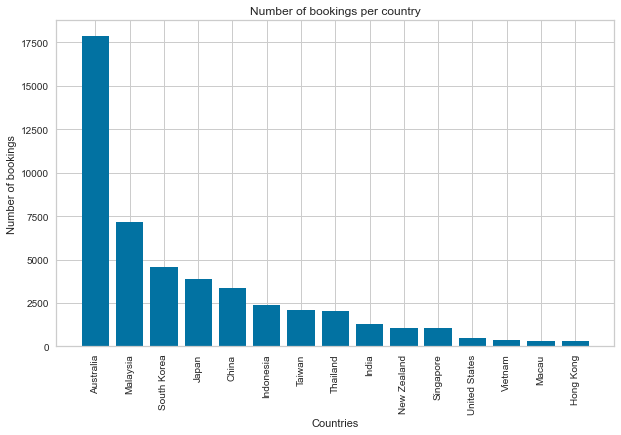

In [221]:
# Extract the country names and their respective counts
x_axis = top_15_countries.index
y_axis = top_15_countries.values

# Create a figure and axis with custom figsize
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
ax.bar(x_axis, y_axis)

# Set labels and title for the plot
ax.set_xlabel("Countries")
ax.set_ylabel("Number of bookings")
ax.set_title("Number of bookings per country")

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

- The plot shows that most of the bookings have Australia as country of origin with 17872 bookings, followed by Malaysia that have 7174 (less than half bookings than Australia)

- South Korea, Japan, and China came as 3rd, 4th and 5th countries. 

Let's find out how many of these bookings are complete bookings. 

In [222]:
# Find top countries with complete bookings 
complete_booking_df = df[df.booking_complete ==1].booking_origin.value_counts()
top_15_complete_booking= complete_booking_df.head(15)
print(top_15_complete_booking)

Malaysia         2468
Australia         900
China             694
Indonesia         615
Japan             478
Thailand          470
South Korea       462
Singapore         299
Taiwan            224
India             131
Vietnam           114
Macau              95
United States      84
Philippines        75
Hong Kong          73
Name: booking_origin, dtype: int64


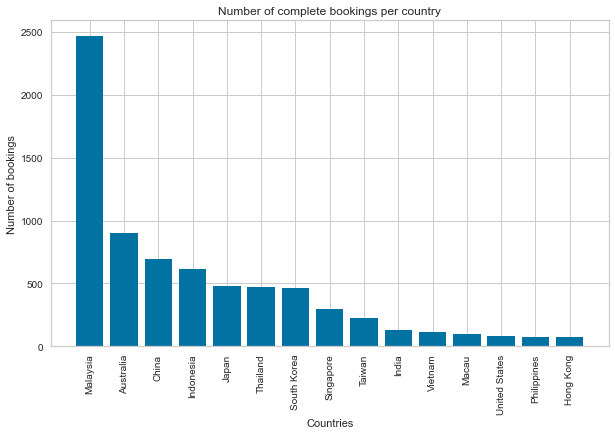

In [223]:
# Extract the country names and their respective counts
x_axis = top_15_complete_booking.index
y_axis = top_15_complete_booking.values

# Create a figure and axis with custom figsize
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
ax.bar(x_axis, y_axis)

# Set labels and title for the plot
ax.set_xlabel("Countries")
ax.set_ylabel("Number of bookings")
ax.set_title("Number of complete bookings per country")

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

- One can notice that Malaysia is the country with the biggest number of complete bookings (2468) followed by Australia (900).
- From 17872 bookings with country of origin as Australia only 900 are complete. 
- China, Indonesia, and Japan are the 3rd, 4th, and 5th country with complete bookings.

## Booking Complete

In [249]:
df.groupby("booking_complete").size()

booking_complete
0    42522
1     7478
dtype: int64

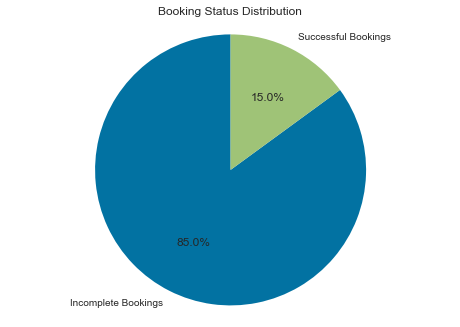

In [263]:
# Data
categories = ['Incomplete Bookings', 'Successful Bookings']
counts = [42522, 7478]
#colors = ['pink', 'magenta']  # Specify the colors for each slice

# Pie chart
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures the circle looks circular
plt.axis('equal')

# Add a title
plt.title('Booking Status Distribution')

# Display the plot
plt.show()

The number of incomplete booking is way bigger than the successful booking. Our data is unbalanced 

## Dummification of data
We need to dummify the columns with object type or drop them

In [224]:
# Dummify sales_channel
df = pd.get_dummies(df, columns=["sales_channel"])
df.head()

,num_passengers,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile
0,2,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1,0
1,1,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1,0
2,2,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1,0
3,1,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1,0
4,2,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1,0


In [225]:
# Rename columns
df = df.rename(columns={'sales_channel_Internet': 'Internet', 
                        'sales_channel_Mobile': 'Mobile'})

In [227]:
# Dummify sales_channel and trip_type
df = pd.get_dummies(df, columns=["trip_type"])
df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,Internet,Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip
0,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1,0,0,0,1
1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1,0,0,0,1
2,2,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1,0,0,0,1
3,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1,0,0,0,1
4,2,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1,0,0,0,1


In [228]:
# Rename columns
df = df.rename(columns={'trip_type_CircleTrip': 'CircleTrip', 
                        'trip_type_OneWay': 'OneWay',
                        'trip_type_RoundTrip': 'RoundTrip'})
df.head()

In [229]:
# Drop booking_origin and. route
df = df.drop(["booking_origin","route"], axis=1)
df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,Internet,Mobile,CircleTrip,OneWay,RoundTrip
0,2,262,19,7,6,1,0,0,5.52,0,1,0,0,0,1
1,1,112,20,3,6,0,0,0,5.52,0,1,0,0,0,1
2,2,243,22,17,3,1,1,0,5.52,0,1,0,0,0,1
3,1,96,31,4,6,0,0,1,5.52,0,1,0,0,0,1
4,2,68,22,15,3,1,0,1,5.52,0,1,0,0,0,1


In [230]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,Internet,Mobile,CircleTrip,OneWay,RoundTrip
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560,0.887640,0.112360,0.002320,0.007740,0.989940
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643,0.315812,0.315812,0.048111,0.087637,0.099795
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Check null values and the number of complete/ incomplete bookings

In [231]:
df.isnull().sum()

num_passengers           0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
Internet                 0
Mobile                   0
CircleTrip               0
OneWay                   0
RoundTrip                0
dtype: int64

In [232]:
df.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

## Correlation Matrix

<AxesSubplot:>

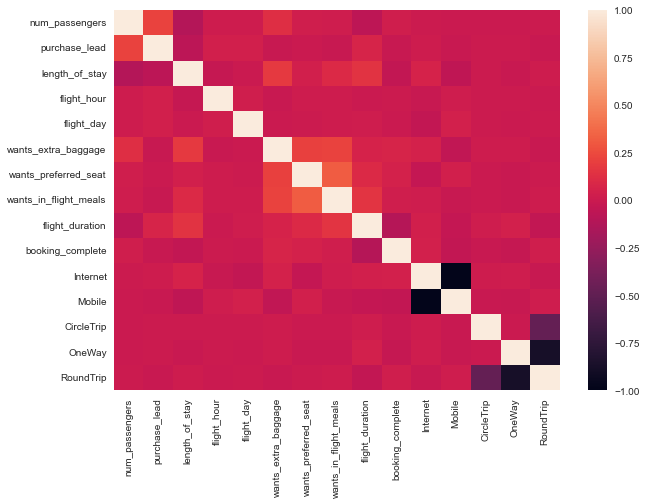

In [241]:
corr = df.corr()

plt.figure(figsize=(10,7))

# Plot the heatmap
sns.heatmap(corr)

## Define features set

In [233]:
X = df.copy()
X = X.drop(["booking_complete"], axis=1)

X.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,CircleTrip,OneWay,RoundTrip
0,2,262,19,7,6,1,0,0,5.52,1,0,0,0,1
1,1,112,20,3,6,0,0,0,5.52,1,0,0,0,1
2,2,243,22,17,3,1,1,0,5.52,1,0,0,0,1
3,1,96,31,4,6,0,0,1,5.52,1,0,0,0,1
4,2,68,22,15,3,1,0,1,5.52,1,0,0,0,1


In [234]:
y = df["booking_complete"].ravel()

## Split into Train and Test Data

In [235]:
# Splitting into Train and Test sets (75%-25% by default)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=78)

In [236]:
# Determine the shape of our training and testing sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37500, 14)
(12500, 14)
(37500,)
(12500,)


## Scale the Data 

In [237]:
# Scale training and testing Data 
# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Compute the mean and the standard deviation of the first column of the scaled data
import numpy as np
print(np.mean(X_train_scaled[:,0]))
print(np.std(X_train_scaled[:,0]))
print(np.mean(X_test_scaled[:,0]))
print(np.std(X_test_scaled[:,0]))

2.6526928801710406e-18
1.0
-0.005571401990843498
0.9837848547227552


# Fitting the Reandom Forest Model

In [238]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=1) 

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

## Making Predictions Using the Tree Model

In [239]:
# Make Predictions Using the Testing Data
predictions = rf_model.predict(X_test_scaled)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [247]:
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


## Evaluate the model
### Checking Testing Accuracy

In [242]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)


# Calculating the testing accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)

print(f'--------------------------')
print(f"Accuracy Score : {acc_score}")
print(f'--------------------------')
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,10519,114
Actual 1,1763,104


--------------------------
Accuracy Score : 0.84984
--------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     10633
           1       0.48      0.06      0.10      1867

    accuracy                           0.85     12500
   macro avg       0.67      0.52      0.51     12500
weighted avg       0.80      0.85      0.80     12500



In [268]:
print('AUC score: ', round(roc_auc_score(y_test, predictions),2))

AUC score:  0.52


## Find features that can drive successful bookings

Text(0.5, 0, 'Random Forest Feature Importance')

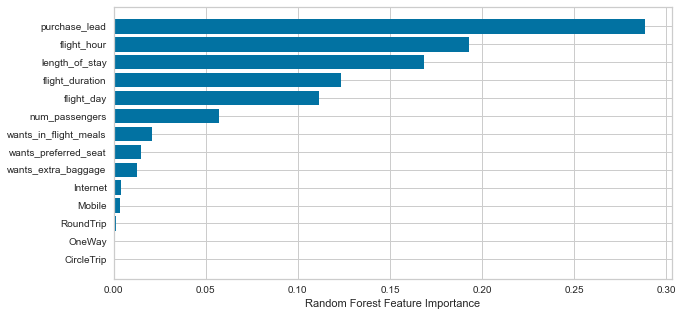

In [244]:
plt.figure(figsize=(10,5))
sorted_id = rf_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_id], rf_model.feature_importances_[sorted_id])
plt.xlabel("Random Forest Feature Importance")